<a href="https://colab.research.google.com/github/Jackkerrison/Jack_lob/blob/main/Copy_of_Running_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Section 1: Environment Setup and Imports
# Install necessary packages
%pip install arch --upgrade
%pip install pathos
!pip install bintrees
%pip install yfinance
%pip install sortedcontainers

# Import necessary modules
import sys
import logging
import psutil
from pathos.multiprocessing import ProcessingPool as Pool
import numpy as np
import pandas as pd
from collections import deque
import time
from sortedcontainers import SortedDict
import random
from arch import arch_model
from io import StringIO
import threading
import tracemalloc
import gc
import yfinance as yf
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import seaborn as sns

# Adjust the CPU monitoring logic
MAX_CPU_PERCENT = 95  # Allow higher CPU usage before pausing
MAX_MEMORY_PERCENT = 90  # Allow higher memory usage
CHECK_INTERVAL = 5  # Check every 5 seconds

def monitor_resources():
    while True:
        cpu_percent = psutil.cpu_percent(interval=1)
        memory_percent = psutil.virtual_memory().percent

        if cpu_percent > MAX_CPU_PERCENT:
            logging.warning(f"High CPU usage: {cpu_percent}%. Pausing execution.")
            time.sleep(1)  # Shorter pause

        if memory_percent > MAX_MEMORY_PERCENT:
            logging.warning(f"High Memory usage: {memory_percent}%. Collecting garbage.")
            gc.collect()
            time.sleep(1)  # Shorter pause

        time.sleep(CHECK_INTERVAL)

# Start monitoring system resources in a separate thread
monitor_thread = threading.Thread(target=monitor_resources, daemon=True)
monitor_thread.start()

  Using cached bintrees-2.2.0.zip (108 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for bintrees
  Running setup.py clean for bintrees
Failed to build bintrees
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (bintrees)


Dropped 0 rows due to missing data. (0.00% of the data)
Preview of the fetched data:
                      Open   High    Low  Close  Adj Close   Volume
Datetime                                                           
2023-05-01 09:30:00 306.97 308.60 306.17 306.32     306.32  4971460
2023-05-01 10:30:00 306.30 307.55 305.77 306.30     306.30  3529718
2023-05-01 11:30:00 306.33 307.46 306.10 307.10     307.10  1811533
2023-05-01 12:30:00 307.10 308.05 307.10 307.58     307.58  1998664
2023-05-01 13:30:00 307.62 307.98 306.40 306.55     306.55  1522938


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


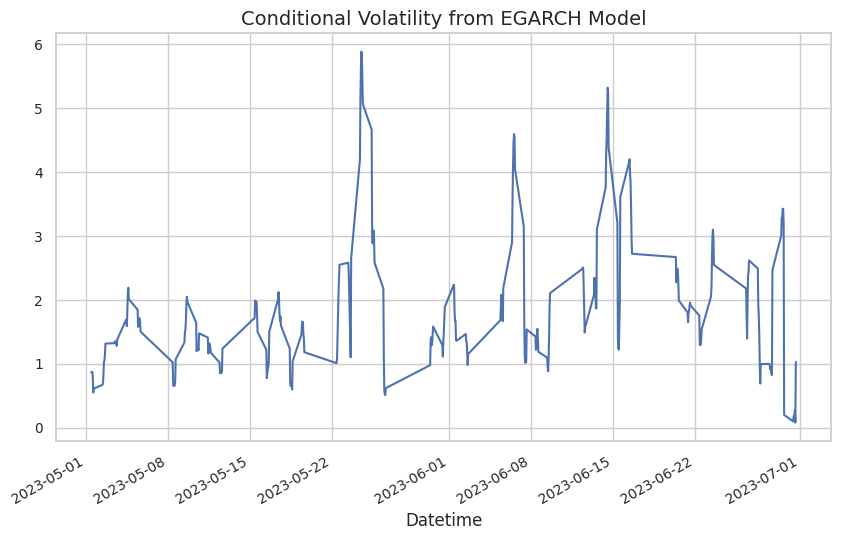

Sample Adjusted Volumes and Liquidity:
                     Adjusted_Volume  Liquidity
Datetime                                       
2023-05-01 09:30:00       1118139.53 1613726.56
2023-05-01 10:30:00        574204.79  383303.29
2023-05-01 11:30:00        268327.90  238708.61
2023-05-01 12:30:00        451768.12  420759.07
2023-05-01 13:30:00        342863.36  242183.79
Sample Bid Prices at different levels:
                     Bid_Price_1  Bid_Price_2  Bid_Price_3  Bid_Price_4  \
Datetime                                                                  
2023-05-01 09:30:00       314.87       314.55       314.24       313.92   
2023-05-01 10:30:00       315.33       315.25       315.18       315.10   
2023-05-01 11:30:00       316.21       316.16       316.11       316.07   
2023-05-01 12:30:00       316.63       316.54       316.46       316.37   
2023-05-01 13:30:00       315.65       315.61       315.56       315.51   

                     Bid_Price_5  Bid_Price_6  Bid_Price_7  

In [18]:
# Data Fetching and Preparation
try:
    # Fetch MSFT data for the specified date range
    msft_data = yf.download('MSFT', start='2023-05-01', end='2023-07-01', interval='60m', progress=False)
    initial_rows = msft_data.shape[0]

    # Handle missing data for 'Adj Close' and 'Volume'
    if msft_data.isnull().sum().sum() > 0:
        msft_data['Adj Close'] = msft_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')
        msft_data['Volume'] = msft_data['Volume'].fillna(msft_data['Volume'].rolling(window=5, min_periods=1).mean())

    dropped_rows = initial_rows - msft_data.shape[0]
    print(f"Dropped {dropped_rows} rows due to missing data. ({(dropped_rows / initial_rows) * 100:.2f}% of the data)")
    print("Preview of the fetched data:")
    print(msft_data.head())

except Exception as e:
    print(f"Error fetching data: {e}")

# Rolling window for volatility calculation
rolling_window = 10
initial_volatility = msft_data['Adj Close'].rolling(window=rolling_window).std().dropna()

# Calculate Returns and GARCH Model Fitting
try:
    returns = msft_data['Adj Close'].pct_change().dropna()
    egarch_fitted = arch_model(returns * 100, vol='EGarch', p=1, q=1, o=1, dist='t').fit(disp='off')
    volatility = (egarch_fitted.conditional_volatility / 100).round(2)

    # Smooth transition of volatility
    if not initial_volatility.empty:
        volatility.iloc[:len(initial_volatility)] = initial_volatility.values
    # Plot the conditional volatility
    volatility.plot(title='Conditional Volatility from EGARCH Model', figsize=(10, 6))
    plt.show()

except Exception as e:
    print(f"Error in GARCH model fitting: {e}")

# Adjusted liquidity calculation
def time_weighted_liquidity(volume, timestamp):
    typical_liquidity_factor = np.random.uniform(0.6, 1.4)  # Tighten the bounds for normal liquidity
    if timestamp.hour < 10:
        return volume * typical_liquidity_factor * np.random.uniform(1.2, 1.6)  # Stronger early morning liquidity
    elif timestamp.hour >= 15:
        return volume * typical_liquidity_factor * np.random.uniform(1.4, 1.8)  # Higher liquidity at close
    else:
        return volume * typical_liquidity_factor * np.random.uniform(0.5, 0.8)  # Lower liquidity midday

# Adjust dynamic liquidity function to make liquidity decay more sensitive to large trades.
def dynamic_liquidity(volume, executed_order_size, base_liquidity, volatility=0.02):
    # Increase the liquidity adjustment to reflect higher liquidity for MSFT
    liquidity_adjustment = np.random.uniform(0.7, 1.2)  # Higher liquidity range
    volatility_impact = volatility * np.random.uniform(1.5, 2.0)  # Volatility impact remains but reduced

    remaining_liquidity = round(max(base_liquidity - (executed_order_size * liquidity_adjustment * volatility_impact), 0), 2)

    return max(remaining_liquidity, volume * 0.05)  # Increase the minimum liquidity threshold

# Align Data
aligned_data = pd.concat([msft_data['Adj Close'], msft_data['Volume'], volatility, msft_data['High'], msft_data['Low']], axis=1).ffill().bfill()
aligned_data.columns = ['Adj Close', 'Volume', 'Volatility', 'High', 'Low']

# Step 1: Calculate Adjusted Volume first
hourly_volume = msft_data['Volume'].resample('H').mean().mean().round(2)  # Example calculation based on average hourly volume
volume_multiplier = np.random.uniform(0.7, 1.3, len(aligned_data))  # More realistic range for liquidity adjustments
aligned_data['Adjusted_Volume'] = ((aligned_data['Volume'] / aligned_data['Volume'].max()) * hourly_volume * volume_multiplier).round(2)

# Step 2: Calculate initial liquidity based on Adjusted_Volume
aligned_data['Liquidity'] = aligned_data.apply(lambda row: time_weighted_liquidity(row['Adjusted_Volume'], row.name), axis=1)

# Step 3: Apply dynamic liquidity adjustment
aligned_data['Liquidity'] = aligned_data.apply(lambda row: dynamic_liquidity(row['Adjusted_Volume'], 100000, row['Liquidity']), axis=1)

# Ensure rounding of liquidity and volumes
aligned_data['Liquidity'] = aligned_data['Liquidity'].round(2)
aligned_data['Adjusted_Volume'] = aligned_data['Adjusted_Volume'].round(2)

# Print volume and liquidity for verification
print("Sample Adjusted Volumes and Liquidity:")
print(aligned_data[['Adjusted_Volume', 'Liquidity']].head())

# More realistic transaction cost calculation based on liquidity, spread, and volatility
def calculate_transaction_cost(executed_volume, avg_price, liquidity, spread, volatility, base_cost=0.0015):
    spread_impact = round(spread / avg_price, 4)
    volatility_impact = round(volatility / avg_price, 4)

    transaction_cost_multiplier = round(1 + spread_impact * np.random.uniform(1.1, 1.3) + volatility_impact * np.random.uniform(1.5, 2.5), 4)
    transaction_cost = round(executed_volume * avg_price * (base_cost * transaction_cost_multiplier), 2)

    return transaction_cost

# Method to calculate volatility based on the recent trades
def calculate_volatility(self, window=10):
    prices = np.array([trade['price'] for trade in self.trades[-window:]])  # Last N trades
    if len(prices) < 2:
        return 0  # Not enough data to calculate volatility
    returns = np.diff(prices) / prices[:-1]
    return np.std(returns) * np.sqrt(len(returns))  # Annualized volatility

# Increase spread dynamically based on market conditions and liquidity
def dynamic_spread(adj_close, volatility, liquidity, base_spread_factor=0.0004, volatility_multiplier=0.7):
    # Increase the spread factor during low liquidity and high volatility
    base_spread = adj_close * base_spread_factor * (1 + volatility * volatility_multiplier)
    liquidity_adjustment = 1 + np.random.uniform(0.06, 0.15)  # Larger adjustment for more variability
    spread = base_spread * liquidity_adjustment
    return np.clip(spread, adj_close * 0.0003, adj_close * 0.002).round(4)  # Adjust the spread range

# Apply the updated spread calculation
aligned_data['Spread'] = aligned_data.apply(
    lambda row: dynamic_spread(row['Adj Close'], row['Volatility'], row['Liquidity']), axis=1)

# Modify the market response function to include a more dynamic market impact factor.
def market_response(price, order_size, daily_volume, liquidity, volatility, market_conditions='stable'):
    market_impact_factor = np.random.uniform(0.05, 0.15) if market_conditions == 'volatile' else np.random.uniform(0.05, 0.1)
    impact = price * (1 + market_impact_factor * ((order_size / liquidity) ** 1.5))  # More sensitive based on order size
    return np.clip(impact, price * 0.97, price * 1.03).round(2)  # Limit to a realistic range

# Use this function in VWAP and TWAP executions
aligned_data['Mid_Price'] = aligned_data.apply(lambda row: market_response(row['Adj Close'], row['Volume'], 20000000, row['Liquidity'], row['Volatility'], 'stable'), axis=1)

# VWAP Calculation
def calculate_vwap(prices, volumes):
    cumulative_price_volume = np.cumsum(prices * volumes)
    cumulative_volume = np.cumsum(volumes)
    vwap = cumulative_price_volume / cumulative_volume
    return vwap.round(2)

aligned_data['VWAP'] = calculate_vwap(aligned_data['Adj Close'], aligned_data['Volume'])

# Calculate Typical Price and TWAP
aligned_data['Typical Price'] = ((aligned_data['Adj Close'] + aligned_data['High'] + aligned_data['Low']) / 3).round(2)

# Refined TWAP Calculation using exponentially weighted moving average (EWMA)
def calculate_twap(prices, alpha=0.05):
    # Further reduce alpha for a smoother TWAP
    return prices.ewm(alpha=alpha, adjust=False).mean().round(2)

aligned_data['TWAP'] = calculate_twap(aligned_data['Typical Price'])

# Distribute bid/ask liquidity across levels with realistic differences
def distribute_liquidity_across_levels(mid_price, liquidity, num_levels):
    level_multipliers = np.exp(-np.arange(num_levels) / 2)
    total_liquidity = liquidity * level_multipliers / level_multipliers.sum()
    return total_liquidity

# Adjust bid/ask prices using increasing spread for each level, with dynamic adjustment for available levels
def generate_bid_ask_prices(aligned_data, num_levels=10):
    # Ensure num_levels does not exceed the number of available data points
    actual_num_levels = min(num_levels, len(aligned_data))  # Ensure levels do not exceed available data points

    # Initialize bid and ask prices arrays with NaN values
    bid_prices = np.full((len(aligned_data), actual_num_levels), np.nan)
    ask_prices = np.full((len(aligned_data), actual_num_levels), np.nan)

    for i in range(actual_num_levels):  # Generate bid/ask prices for each level
        spread_multiplier = 1 + i * 0.5  # Adjust spread by increasing the multiplier
        liquidity_impact = aligned_data['Liquidity'].values / aligned_data['Liquidity'].mean()

        # Generate bid and ask prices by adjusting Mid_Price with spread and liquidity impact
        bid_prices[:, i] = aligned_data['Mid_Price'].values - (aligned_data['Spread'].values * spread_multiplier * liquidity_impact)
        ask_prices[:, i] = aligned_data['Mid_Price'].values + (aligned_data['Spread'].values * spread_multiplier * liquidity_impact)

    # Create DataFrames for bid and ask prices with column names for each level
    bid_prices_df = pd.DataFrame(bid_prices, index=aligned_data.index, columns=[f'Bid_Price_{i+1}' for i in range(num_levels)])
    ask_prices_df = pd.DataFrame(ask_prices, index=aligned_data.index, columns=[f'Ask_Price_{i+1}' for i in range(num_levels)])

    return bid_prices_df, ask_prices_df

# Generate bid and ask prices
df_bid_prices, df_ask_prices = generate_bid_ask_prices(aligned_data, num_levels=10)

# Ensure that bid/ask prices are not empty and aligned_data contains valid data before concatenating
if not df_bid_prices.empty and not df_ask_prices.empty:
    aligned_data = pd.concat([aligned_data, df_bid_prices, df_ask_prices], axis=1)
else:
    print("[DEBUG] Bid or Ask prices DataFrames are empty. Check the data generation logic.")

# Print bid and ask prices for verification
print("Sample Bid Prices at different levels:")
print(df_bid_prices.head())

print("Sample Ask Prices at different levels:")
print(df_ask_prices.head())

# Display order book summary with adjusted format
pd.options.display.float_format = '{:.2f}'.format
print("Order book summary:\n", aligned_data.describe().transpose())

<ipython-input-19-f197f8e66a2e>:53: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aligned_data['Order_Imbalance'] = (bid_volumes - ask_volumes).rolling(window=5).mean().fillna(method='bfill')
<ipython-input-19-f197f8e66a2e>:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[4, 0].set_xticklabels(axes[4, 0].get_xticklabels(), rotation=45)
<ipython-input-19-f197f8e66a2e>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


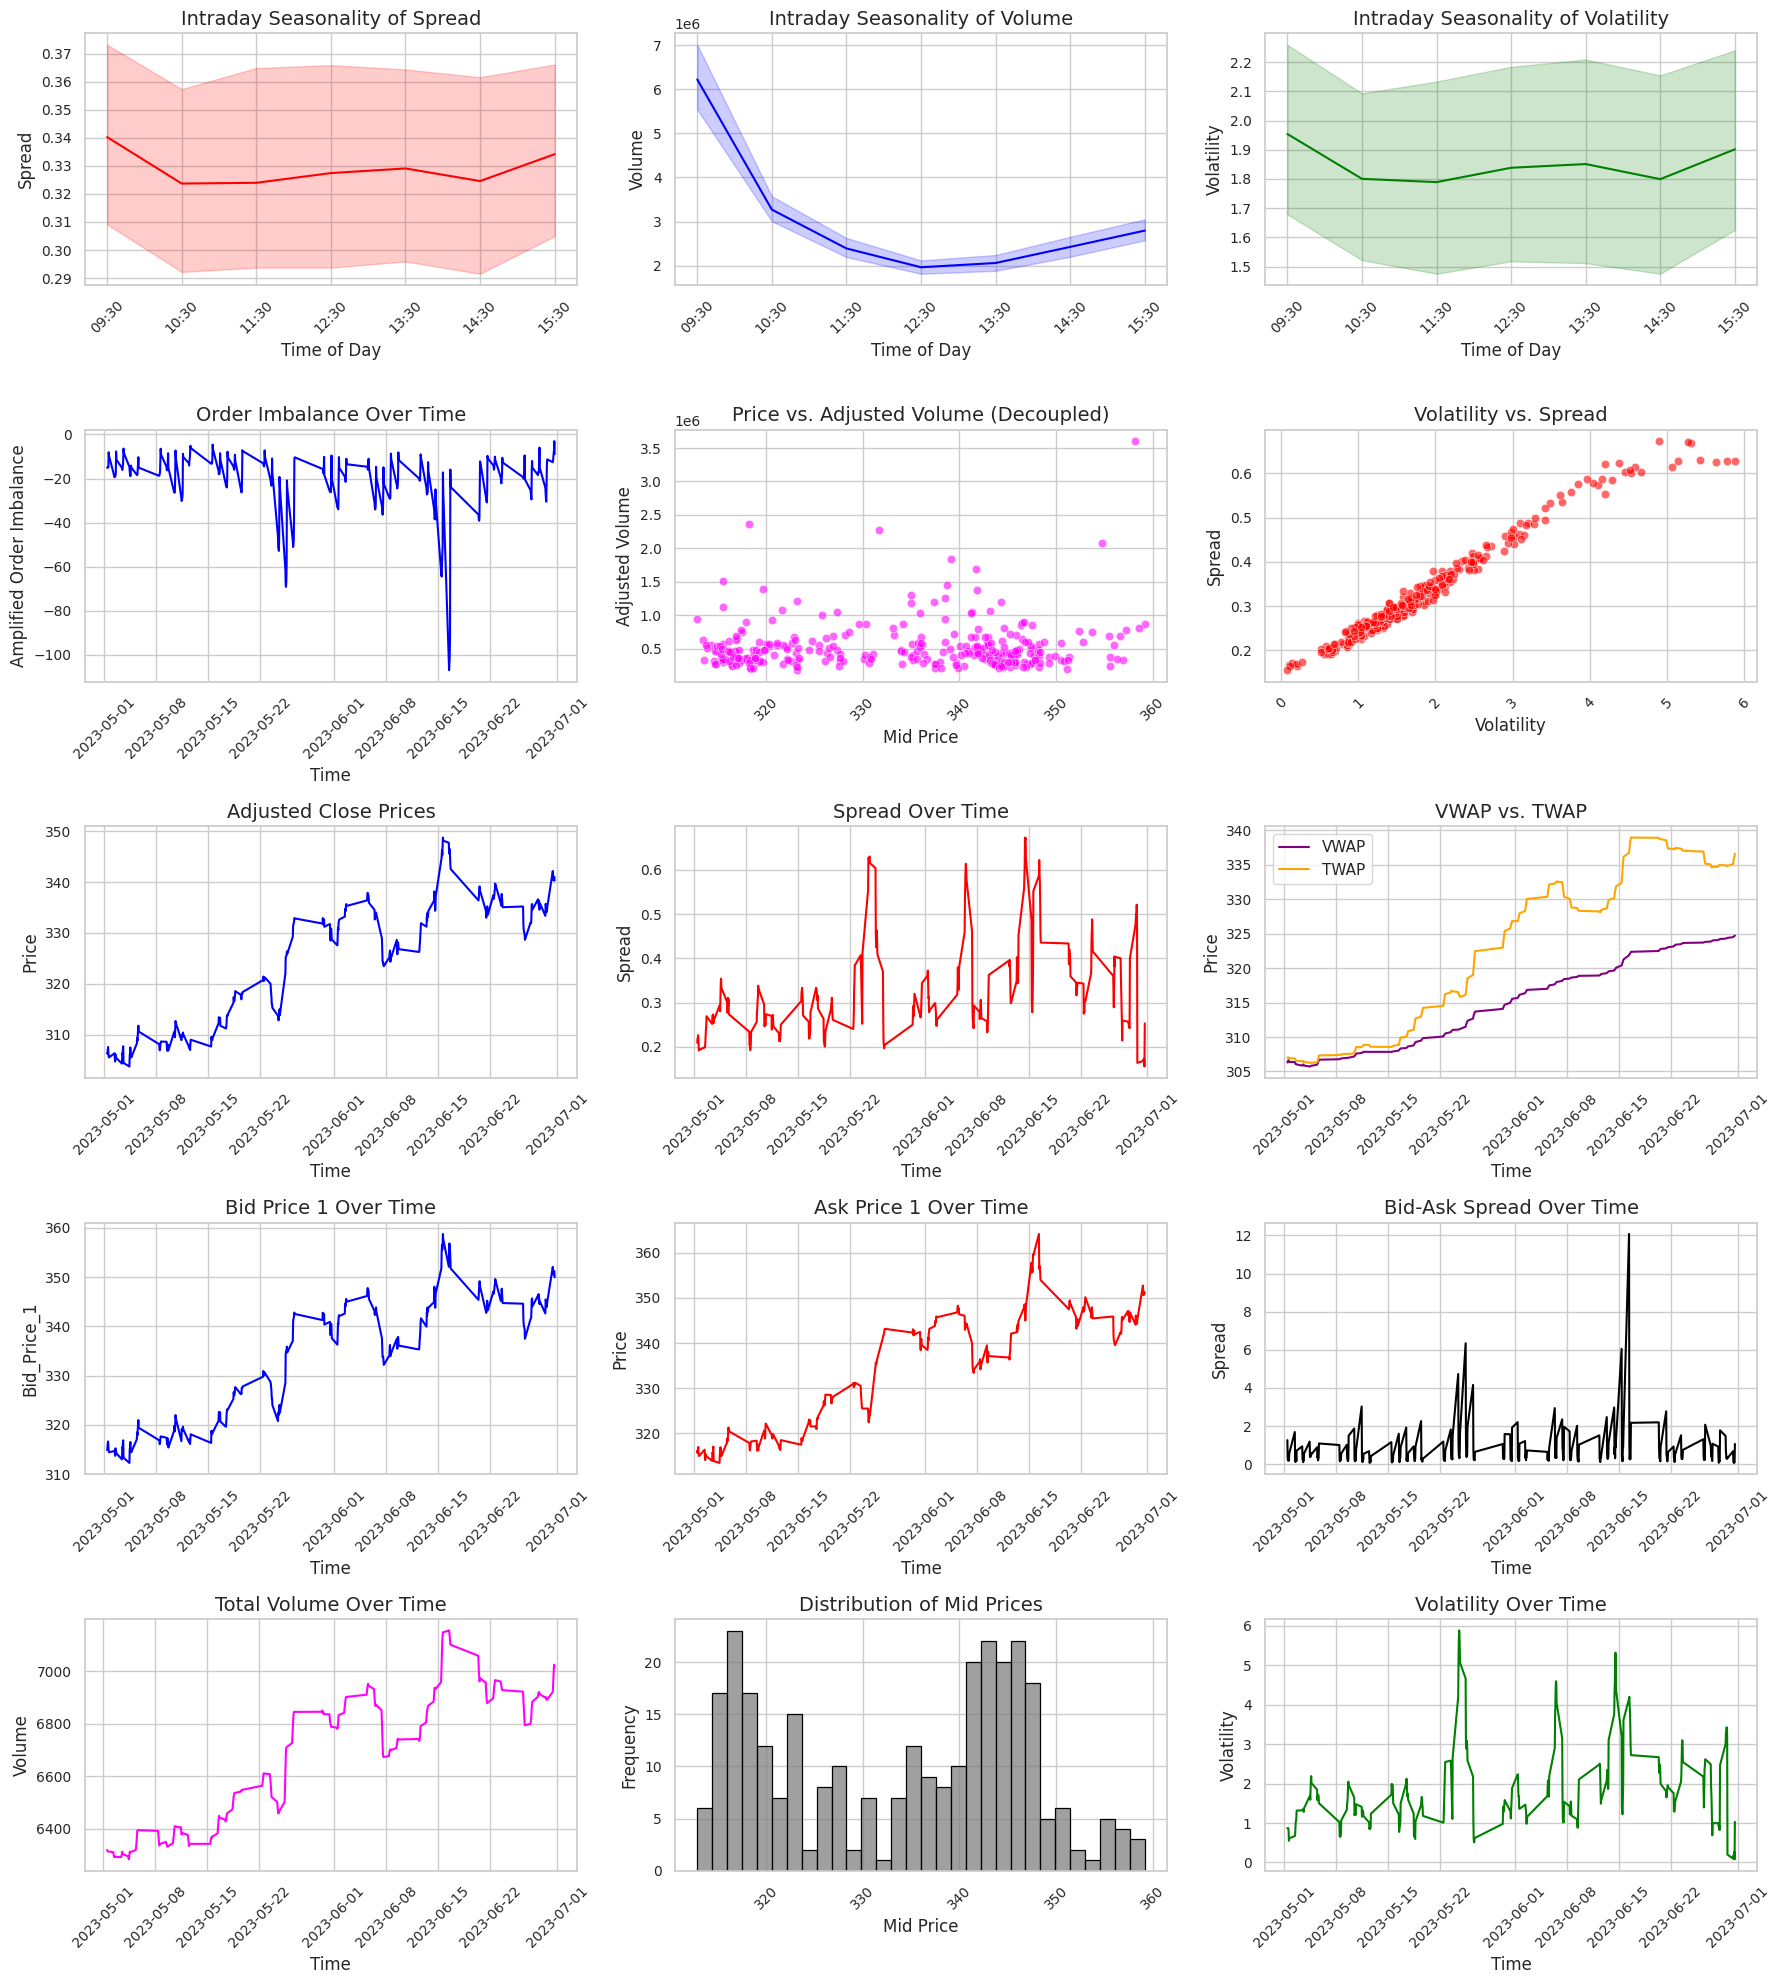

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the index is a datetime object
aligned_data.index = pd.to_datetime(aligned_data.index)

# Grouping the data by time-of-day to observe intraday patterns
aligned_data['Time_of_Day'] = aligned_data.index.time

# Convert Time_of_Day to a string representation of time (HH:MM)
aligned_data['Time_of_Day'] = aligned_data['Time_of_Day'].apply(lambda x: x.strftime('%H:%M'))

# Set the style and palette for the plots
sns.set(style="whitegrid")
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Create a figure with multiple subplots
fig, axes = plt.subplots(5, 3, figsize=(18, 20))  # Adjusted to fit 15 plots (5 rows, 3 columns)

# 1. Spread over the day
sns.lineplot(x='Time_of_Day', y='Spread', data=aligned_data, ax=axes[0, 0], color='red')
axes[0, 0].set_title('Intraday Seasonality of Spread')
axes[0, 0].set_xlabel('Time of Day')
axes[0, 0].set_ylabel('Spread')

# 2. Volume over the day
sns.lineplot(x='Time_of_Day', y='Volume', data=aligned_data, ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Intraday Seasonality of Volume')
axes[0, 1].set_xlabel('Time of Day')
axes[0, 1].set_ylabel('Volume')

# 3. Volatility over the day
sns.lineplot(x='Time_of_Day', y='Volatility', data=aligned_data, ax=axes[0, 2], color='green')
axes[0, 2].set_title('Intraday Seasonality of Volatility')
axes[0, 2].set_xlabel('Time of Day')
axes[0, 2].set_ylabel('Volatility')

# Order Imbalance Calculation
# Dynamically check the number of bid/ask price levels available in the DataFrame
available_bid_levels = [col for col in aligned_data.columns if col.startswith('Bid_Price_')]
available_ask_levels = [col for col in aligned_data.columns if col.startswith('Ask_Price_')]

# Calculate the total volume by summing the available bid and ask price levels
aligned_data['Total_Volume'] = aligned_data[available_bid_levels].sum(axis=1) + aligned_data[available_ask_levels].sum(axis=1)

# Ensure we are only accessing available columns
bid_volumes = aligned_data[available_bid_levels].sum(axis=1)
ask_volumes = aligned_data[available_ask_levels].sum(axis=1)
# Apply smoothing and clipping to the order imbalance calculation
aligned_data['Order_Imbalance'] = (bid_volumes - ask_volumes).rolling(window=5).mean().fillna(method='bfill')
aligned_data['Order_Imbalance'] = aligned_data['Order_Imbalance'].clip(lower=-5000, upper=5000)
sns.lineplot(x=aligned_data.index, y=aligned_data['Order_Imbalance'], ax=axes[1, 0], color='blue')
axes[1, 0].set_title('Order Imbalance Over Time')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Amplified Order Imbalance')

# 5. Price vs Adjusted Volume (Decoupled)
sns.scatterplot(x=aligned_data['Mid_Price'], y=aligned_data['Adjusted_Volume'], ax=axes[1, 1], color='magenta', alpha=0.6)
axes[1, 1].set_title('Price vs. Adjusted Volume (Decoupled)')
axes[1, 1].set_xlabel('Mid Price')
axes[1, 1].set_ylabel('Adjusted Volume')

# 6. Volatility vs Spread Scatter Plot
sns.scatterplot(x=aligned_data['Volatility'], y=aligned_data['Spread'], ax=axes[1, 2], color='red', alpha=0.6)
axes[1, 2].set_title('Volatility vs. Spread')
axes[1, 2].set_xlabel('Volatility')
axes[1, 2].set_ylabel('Spread')

# 7. Adjusted Close Prices Over Time
sns.lineplot(x=aligned_data.index, y='Adj Close', data=aligned_data, ax=axes[2, 0], color='blue')
axes[2, 0].set_title('Adjusted Close Prices')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Price')

# 8. Spread Over Time
sns.lineplot(x=aligned_data.index, y='Spread', data=aligned_data, ax=axes[2, 1], color='red')
axes[2, 1].set_title('Spread Over Time')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Spread')

# 9. VWAP vs TWAP
sns.lineplot(x=aligned_data.index, y='VWAP', data=aligned_data, ax=axes[2, 2], color='purple', label='VWAP')
sns.lineplot(x=aligned_data.index, y='TWAP', data=aligned_data, ax=axes[2, 2], color='orange', label='TWAP')
axes[2, 2].set_title('VWAP vs. TWAP')
axes[2, 2].set_xlabel('Time')
axes[2, 2].set_ylabel('Price')
axes[2, 2].legend()

# 10. Bid Price 1 Over Time
# Check if 'Bid_Price_1' exists before plotting
if 'Bid_Price_1' in aligned_data.columns:
    sns.lineplot(x=aligned_data.index, y='Bid_Price_1', data=aligned_data, ax=axes[3, 0], color='blue')
    axes[3, 0].set_title('Bid Price 1 Over Time')
    axes[3, 0].set_xlabel('Time')
else:
    print("[DEBUG] 'Bid_Price_1' column not found in aligned_data. Check the bid price generation.")

# 11. Ask Price 1 Over Time
sns.lineplot(x=aligned_data.index, y='Ask_Price_1', data=aligned_data, ax=axes[3, 1], color='red')
axes[3, 1].set_title('Ask Price 1 Over Time')
axes[3, 1].set_xlabel('Time')
axes[3, 1].set_ylabel('Price')

# 12. Bid-Ask Spread Over Time
bid_ask_spread = aligned_data['Ask_Price_1'] - aligned_data['Bid_Price_1']
sns.lineplot(x=aligned_data.index, y=bid_ask_spread, ax=axes[3, 2], color='black')
axes[3, 2].set_title('Bid-Ask Spread Over Time')
axes[3, 2].set_xlabel('Time')
axes[3, 2].set_ylabel('Spread')

# 13. Total Volume (Bid + Ask) Over Time
# Calculate Total Volume (Bid + Ask)
aligned_data['Total_Volume'] = aligned_data[[f'Bid_Price_{i+1}' for i in range(10)]].sum(axis=1) + aligned_data[[f'Ask_Price_{i+1}' for i in range(10)]].sum(axis=1)
aligned_data['Smoothed_Total_Volume'] = aligned_data['Total_Volume'].rolling(window=5).mean()
sns.lineplot(x=aligned_data.index, y=aligned_data['Smoothed_Total_Volume'], ax=axes[4, 0], color='magenta')
axes[4, 0].set_xticklabels(axes[4, 0].get_xticklabels(), rotation=45)
axes[4, 0].set_title('Total Volume Over Time')
axes[4, 0].set_xlabel('Time')
axes[4, 0].set_ylabel('Volume')

# 14. Distribution of Mid Prices
sns.histplot(aligned_data['Mid_Price'], bins=30, kde=False, color='grey', ax=axes[4, 1], edgecolor='black')
axes[4, 1].set_title('Distribution of Mid Prices')
axes[4, 1].set_xlabel('Mid Price')
axes[4, 1].set_ylabel('Frequency')

# 15. Volatility Over Time
sns.lineplot(x=aligned_data.index, y='Volatility', data=aligned_data, ax=axes[4, 2], color='green')
axes[4, 2].set_title('Volatility Over Time')
axes[4, 2].set_xlabel('Time')
axes[4, 2].set_ylabel('Volatility')

# Rotating x-axis labels for all subplots that require it
for ax in axes.flat:  # This iterates through each subplot in the figure
    if len(ax.get_xticklabels()) > 0:  # Check if the subplot has x-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust layout and show all plots
plt.tight_layout()
plt.show()

In [20]:
class Order:
    def __init__(self, price, quantity, tid):
        self.price = round(price, 2)
        self.quantity = round(quantity, 2)
        self.tid = tid  # Store the tid (transaction ID)

class OrderBook:
    def __init__(self, transaction_cost=0.001):
        self.bids = SortedDict(lambda x: -x)  # Sorted descending
        self.asks = SortedDict()  # Sorted ascending
        self.trades = []
        self.transaction_cost = transaction_cost
        self.liquidity_fluctuation_factor = 0.1
        self.external_order_probability = 0.2
        self.mean_reversion_strength = 0.1

        # Initialize the order book with market maker orders and simulate continuous order flow
        self.reset_order_book()

    def reset_order_book(self):
        self.mid_price = 335  # You may set this to any realistic initial value or calculate it dynamically
        self._generate_market_maker_orders()  # Generate the initial market maker orders
        #self._simulate_continuous_order_flow()  # Start the continuous order flow simulation

    # Method to calculate volatility based on recent trades
    def calculate_volatility(self, window=10):
        # If there are not enough trades, return zero volatility
        if len(self.trades) < window:
            return 0

        # Extract the prices from the last 'window' number of trades
        prices = np.array([trade['price'] for trade in self.trades[-window:]])

        # If there is only one unique price, volatility is zero
        if len(np.unique(prices)) == 1:
            return 0

        # Calculate percentage returns
        returns = np.diff(prices) / prices[:-1]

        # Calculate the standard deviation of returns (volatility)
        volatility = np.std(returns) * np.sqrt(len(returns))  # Annualized volatility adjustment (optional)

        return volatility

    def _generate_new_price_levels(self):
        # Ensure there are always at least 10 levels on the bid side
        if len(self.bids) < 10:
            for i in range(len(self.bids), 10):  # Adjust to ensure valid levels
                new_bid_price = self.get_mid_price() - (i * 0.1)
                self.bids[new_bid_price] = deque([Order(new_bid_price, np.random.randint(500, 2000), f'bid-{i}')])
                print(f"[DEBUG] Added bid price level: {new_bid_price}")

        # Ensure there are always at least 10 levels on the ask side
        if len(self.asks) < 10:
            for i in range(len(self.asks), 10):  # Adjust to ensure valid levels
                new_ask_price = self.get_mid_price() + (i * 0.1)
                self.asks[new_ask_price] = deque([Order(new_ask_price, np.random.randint(500, 2000), f'ask-{i}')])
                print(f"[DEBUG] Added ask price level: {new_ask_price}")

    # Adjust slippage to reflect more realistic values
    def _calculate_slippage(self, executed_qty, liquidity, market_conditions='stable', volatility=0.02):
        base_slippage = 0.03  # Higher base slippage for large executions
        liquidity_impact = (executed_qty / liquidity) ** 1.25 if liquidity > 0 else 0  # Adjusted sensitivity
        volatility_impact = np.random.uniform(2.0, 3.0) * volatility  # Increase volatility impact
        slippage = base_slippage * (1 + liquidity_impact * volatility_impact * 10)  # Amplified result
        return slippage

    def _process_market_order(self, order):
        opposite_side = self.asks if order['side'] == 'bid' else self.bids
        remaining_qty = order['qty']
        total_cost = 0
        executed_volume = 0
        slippage_total = 0  # Initialize slippage total

        if not opposite_side:
            print("No available liquidity on the opposite side.")
            return 0, 0, 0, 0  # Early exit if no liquidity

        initial_price = next(iter(opposite_side))

        print(f"Processing market order: {order['qty']} shares on side {order['side']} at target price {initial_price}.")

        while remaining_qty > 0 and opposite_side:
            best_price = next(iter(opposite_side))
            best_order = opposite_side[best_price][0]
            trade_qty = min(best_order.quantity, remaining_qty)
            liquidity = sum(order.quantity for order in opposite_side[best_price])

            # Calculate slippage dynamically based on trade size, liquidity, and market conditions
            volatility = self.calculate_volatility()  # Use the calculated volatility from your model
            slippage = round(self._calculate_slippage(trade_qty, liquidity, 'volatile', volatility), 4)
            slippage_total += slippage * trade_qty  # Accumulate total slippage

            # Adjust the executed price based on slippage
            executed_price = round(best_price * (1 + slippage), 2)

            print(f"Matching order: Price {best_price:.2f}, Qty {trade_qty}, Executed price: {executed_price:.2f}, Liquidity: {liquidity}")

            # Append trade to trade history
            self.trades.append({'price': executed_price, 'qty': trade_qty})
            remaining_qty -= trade_qty
            best_order.quantity -= trade_qty
            executed_volume += trade_qty  # Accumulate executed volume
            total_cost += trade_qty * executed_price  # Accumulate total cost

            # Remove the best order if fully filled
            if best_order.quantity == 0:
                opposite_side[best_price].popleft()
                if not opposite_side[best_price]:
                    del opposite_side[best_price]

            # Stop if no more orders are available on the opposite side
            if not opposite_side:
                break

        # Calculate average price and other metrics
        avg_price = round(total_cost / executed_volume, 2) if executed_volume > 0 else 0
        market_impact = self._simulate_market_impact(executed_volume, liquidity, volatility)  # Pass volatility
        slippage_percentage = self._calculate_slippage(executed_volume, liquidity, 'volatile', volatility)

        return executed_volume, avg_price, slippage_percentage, market_impact

    # Replace the previous order book generation method with this
    def _generate_market_maker_orders(self):
        spread = 0.25
        liquidity_range = (1000, 5000)
        for i in range(15):
            bid_price = self.mid_price - i * spread
            ask_price = self.mid_price + i * spread
            self.bids[bid_price] = deque([Order(bid_price, np.random.randint(*liquidity_range), f'bid-{i}')])
            self.asks[ask_price] = deque([Order(ask_price, np.random.randint(*liquidity_range), f'ask-{i}')])

    def calculate_vwap(self, trades):
        if not trades:
            return 0
        prices = np.array([trade['price'] for trade in trades])
        quantities = np.array([trade['qty'] for trade in trades])
        cumulative_price_volume = np.cumsum(prices * quantities)
        cumulative_volume = np.cumsum(quantities)
        vwap = cumulative_price_volume / cumulative_volume
        vwap_value = round(vwap[-1], 2)

        # Add logging
        vwap_value = round(vwap_value, 2)
        print(f"VWAP Calculation: {vwap_value}, based on {len(trades)} trades.")

        return vwap_value

    def calculate_twap(self, trades):
        if not trades:
            return 0
        times = np.linspace(1, len(trades), len(trades))  # Time intervals, starting from 1
        weighted_prices = [trade['price'] for trade in trades]

        # Ensure no division by zero occurs if weights (times) are all zero
        if np.sum(times) == 0:
            return 0
        twap = np.average(weighted_prices, weights=times)
        twap_value = round(twap, 2)

        # Add logging
        print(f"TWAP Calculation: {twap_value}, based on {len(trades)} trades.")

        return twap_value

    def process_order(self, order):
        # Introduce randomness to simulate other market participants
        if np.random.rand() < self.external_order_probability:
            self._generate_external_order()

        if order['type'] == 'limit':
            self._process_limit_order(order)
        elif order['type'] == 'market':
            # Process the market order
            executed_volume, avg_price, slippage_percentage, market_impact = self._process_market_order(order)

            # Calculate VWAP and TWAP after processing the order
            vwap_value = self.calculate_vwap(self.trades)
            twap_value = self.calculate_twap(self.trades)

            # Add detailed logging of the execution
            total_order_qty = order['qty']
            remaining_qty = total_order_qty - executed_volume

            # Log the execution details with remaining quantity
            print(f"Order: {total_order_qty} shares; Executed: {executed_volume}, Remaining: {remaining_qty}")
            print(f"Average Price: {avg_price:.2f}, Slippage: {slippage_percentage:.2f}%, Market Impact: {market_impact:.4f}")
            print(f"VWAP: {vwap_value}, TWAP: {twap_value}")
        else:
            print(f"Unknown order type: {order['type']}")

    def _process_limit_order(self, order):
        side = self.bids if order['side'] == 'bid' else self.asks
        opposite = self.asks if order['side'] == 'bid' else self.bids
        price = round(order['price'], 2)  # Ensure prices are rounded
        qty = order['qty']

        # Add a print statement at the start of limit order processing for visibility
        print(f"Processing limit order: {qty} shares on side {order['side']} at price {price}.")

        # Attempt to match against opposite orders
        while qty > 0 and opposite:
            best_price = opposite.peekitem(0)[0]  # Get the best price from the opposite side

            if (order['side'] == 'bid' and price >= best_price) or (order['side'] == 'ask' and price <= best_price):
                best_orders = opposite[best_price]  # Get the best orders at the best price
                while qty > 0 and best_orders:
                    best_order = best_orders[0]
                    trade_qty = min(qty, best_order.quantity)  # Determine the trade quantity
                    executed_price = round(best_price * (1 + self.transaction_cost * (-1 if order['side'] == 'bid' else 1)), 2)  # Adjust price with transaction cost

                    # Append trade details to the trade history
                    self.trades.append({'price': executed_price, 'qty': trade_qty})
                    qty -= trade_qty  # Reduce the remaining quantity to be matched
                    best_order.quantity -= trade_qty  # Reduce the quantity of the matched order

                    # Log executed and remaining quantities
                    print(f"Order: {order['qty']} shares; Executed: {order['qty'] - qty}, Remaining: {qty}")

                    # Remove the order if fully executed
                    if best_order.quantity == 0:
                        best_orders.popleft()
                    if not best_orders:
                        del opposite[best_price]
            else:
                break  # Exit the loop if no more matching is possible

        # Add the remaining quantity to the book if it's not fully matched
        if qty > 0:
            if price in side:
                side[price].append(Order(price, qty, order['tid']))
            else:
                side[price] = deque([Order(price, qty, order['tid'])])

    def _fluctuate_liquidity(self, side):
        # Apply random adjustments to the remaining liquidity in the order book
        for price, orders in list(side.items()):
            for order in orders:
                # Adjust the quantity slightly to simulate changing liquidity
                fluctuation_factor = np.random.uniform(0.8, 1.2)  # Small random variation in liquidity
                order.quantity = max(1, int(order.quantity * fluctuation_factor))  # Ensure the quantity is at least 1

        # Optionally, you could remove prices with extremely low liquidity
        for price in list(side.keys()):
            if sum(order.quantity for order in side[price]) <= 1:  # If liquidity is very low, remove the price level
                del side[price]

    def _generate_external_order(self):
        side = 'bid' if np.random.rand() > 0.5 else 'ask'
        price = self._get_random_price(side)
        qty = np.random.randint(500, 2000)  # Generate larger random orders to keep the order book liquid
        order = {
            'type': 'limit',
            'side': side,
            'price': price,
            'qty': qty,
            'tid': 'external'
        }
        self.process_order(order)
        print(f"[DEBUG] Generated external {side} order at price {price} for {qty} shares.")

    # Add this new function within the OrderBook class
    def _generate_incoming_order(self):
        side = 'bid' if np.random.rand() > 0.5 else 'ask'
        price = self._get_random_price(side)
        qty = np.random.randint(500, 2000)
        order_type = np.random.choice(['limit', 'market'])
        order = {
            'type': order_type,
            'side': side,
            'price': price,
            'qty': qty,
            'tid': 'external'
        }
        self.process_order(order)

    def _simulate_continuous_order_flow(self):
        while True:
            if np.random.rand() < self.external_order_probability:
                self._generate_incoming_order()
                self._adjust_liquidity()
            time.sleep(np.random.uniform(0.2, 1.0))  # Adjust the timing to simulate realistic order flow

    def _ensure_residual_liquidity(self, side):
        # Make sure there is a minimum liquidity at each price level
        for price, orders in side.items():
            total_quantity = sum(order.quantity for order in orders)
            if total_quantity < 100:  # Arbitrary threshold for residual liquidity
                orders[-1].quantity += 100  # Ensure at least 100 units remain at each price level

    def get_mid_price(self):
        if self.asks and self.bids:
            return (min(self.asks.keys()) + max(self.bids.keys())) / 2  # Simple average of best bid and ask
        else:
            return 100.0  # Fallback mid-price if the book is empty

    def _initialize_market_maker(self):
        # Generate market maker orders
        self._generate_market_maker_orders()

        # Start simulating continuous order flow
        self._simulate_continuous_order_flow()

    # Update market impact calculation to scale more aggressively based on order size and liquidity
    def _simulate_market_impact(self, executed_qty, liquidity, volatility=0.01, base_impact=0.001):
        if liquidity == 0:
            return base_impact  # Prevent division by zero

        # Market impact should increase with order size relative to liquidity and volatility
        impact_factor = (executed_qty / liquidity) * (1 + volatility * np.random.uniform(1.5, 3.0))  # Add volatility sensitivity

        market_impact = base_impact * (1 + impact_factor)

        # Clip the market impact to ensure it's within realistic bounds (e.g., 0.1% to 1%)
        return np.clip(market_impact, 0.001, 0.01)

    def _mean_reversion(self):
        for side in [self.bids, self.asks]:
            for price in list(side.keys()):
                reverted_price = price * (1 - self.mean_reversion_strength * 0.5)
                if reverted_price in side:
                    side[reverted_price].extend(side[price])
                else:
                    side[reverted_price] = side[price]
                del side[price]

    def _get_random_price(self, side):
        # Assume realistic prices are around the mid-price range of the data, e.g., 300-350.
        realistic_price_range = (300, 350)

        if side == 'bid' and self.bids:
            return round(max(self.bids.keys()) * np.random.uniform(0.99, 1.01), 2)
        elif side == 'ask' and self.asks:
            return round(min(self.asks.keys()) * np.random.uniform(0.99, 1.01), 2)
        else:
            mid_price = np.random.uniform(*realistic_price_range)
            return round(mid_price * np.random.uniform(0.99, 1.01), 2)

    # Adjust the rate at which liquidity replenishes after orders are executed
    def _adjust_liquidity(self):
        for price in list(self.bids.keys()):
            for order in self.bids[price]:
                # Reduce replenishment rate, making liquidity decay more significant
                order.quantity = max(100, int(order.quantity * np.random.uniform(0.7, 1.1)))
        for price in list(self.asks.keys()):
            for order in self.asks[price]:
                order.quantity = max(100, int(order.quantity * np.random.uniform(0.7, 1.1)))

    def _adjust_spread(self):
        for price in list(self.bids.keys()):
            self.bids[price] *= np.random.uniform(1.01, 1.05)  # Widen spread slightly on bids
        for price in list(self.asks.keys()):
            self.asks[price] *= np.random.uniform(1.01, 1.05)  # Widen spread slightly on asks

    def print_book(self, levels=5):
        print("\nOrder Book Snapshot:")
        print("Asks:")
        for price, orders in list(self.asks.items())[:levels]:
            total_qty = sum(order.quantity for order in orders)
            print(f"Price: {price:.2f}, Total Quantity: {round(total_qty, 2)}")
        print("Bids:")
        for price, orders in list(self.bids.items())[:levels]:
            total_qty = sum(order.quantity for order in orders)
            print(f"Price: {price:.2f}, Total Quantity: {round(total_qty, 2)}")

    def print_trades(self):
        print("\nTrades:")
        for trade in self.trades:
            print(f"Traded {trade['qty']} @ {trade['price']:.2f}")

In [21]:
# Function to check the current state of the order book
def check_order_book_state(lob):
    print("[DEBUG] Checking order book state...")

    print("[DEBUG] Bids in the order book (Top 5 Levels):")
    if isinstance(lob.bids, dict) and len(lob.bids) > 0:
        for price, orders in list(lob.bids.items())[:5]:  # Print the top 5 levels of bids
            total_qty = sum(order.quantity for order in orders)
            print(f"Price: {price:.2f}, Total Quantity: {total_qty}")
    else:
        print("[DEBUG] No bids available.")

    print("[DEBUG] Asks in the order book (Top 5 Levels):")
    if isinstance(lob.asks, dict) and len(lob.asks) > 0:
        for price, orders in list(lob.asks.items())[:5]:  # Print the top 5 levels of asks
            total_qty = sum(order.quantity for order in orders)
            print(f"Price: {price:.2f}, Total Quantity: {total_qty}")
    else:
        print("[DEBUG] No asks available.")

# Set a default value for num_levels, e.g., 10
num_levels = 10

def populate_order_book(lob, aligned_data):
    print("\n[DEBUG] Populating the order book with initial data...")

    for index, row in aligned_data.iterrows():
        mid_price = row['Mid_Price']
        liquidity = liq = round(row['Liquidity'] / 10, 2)

        # Dynamically handle max levels based on the available columns
        bid_cols = [col for col in row.index if 'Bid_Price_' in col and not pd.isna(row[col])]
        ask_cols = [col for col in row.index if 'Ask_Price_' in col and not pd.isna(row[col])]

        # Set max levels based on the smaller of bid/ask levels or 10
        max_levels = min(10, len([col for col in aligned_data.columns if 'Bid_Price_' in col]),
                 len([col for col in aligned_data.columns if 'Ask_Price_' in col]))

        if max_levels == 0:
            print(f"[DEBUG] No valid bid/ask levels for row {index}. Skipping this entry.")
            continue

        available_levels = min(num_levels, len([col for col in row.index if 'Bid_Price_' in col]))

        for level in range(1, available_levels + 1):  # Adjust based on available levels
            bid_price_col = 'Bid_Price_{}'.format(level)
            ask_price_col = 'Ask_Price_{}'.format(level)


            # Check for valid bid prices and process bid orders
            if bid_price_col in row and not pd.isna(row[bid_price_col]):
                bid_order = {
                    'type': 'limit',
                    'side': 'bid',
                    'price': row[bid_price_col],
                    'qty': liquidity,
                    'tid': 'bid-{}-{}'.format(index, level)  # Create unique tid
                }
                lob.process_order(bid_order)

            # Check for valid ask prices and process ask orders
            if ask_price_col in row and not pd.isna(row[ask_price_col]):
                ask_order = {
                    'type': 'limit',
                    'side': 'ask',
                    'price': row[ask_price_col],
                    'qty': liquidity,
                    'tid': 'ask-{}-{}'.format(index, level)  # Create unique tid
                }
                lob.process_order(ask_order)

    print("\n[DEBUG] Initial Order Book Snapshot (Top 5 Levels):")
    lob.print_book(levels=5)  # Display the top 5 levels

def execute_vwap_order_with_shares(lob, total_shares):
    executed_volume, total_cost = 0, 0
    remaining_shares = total_shares
    lob.trades.clear()

    vwap_prices, vwap_volumes, vwap_slippage, vwap_market_impact = [], [], [], []

    print(f"\n[DEBUG] VWAP function started to buy {total_shares} shares.", flush=True)
    lob.print_book(levels=5)  # Print the top 5 levels of the order book before execution

    while remaining_shares > 0:
        print(f"\n[DEBUG] VWAP loop - remaining shares: {remaining_shares}.", flush=True)

        # Ensure enough levels are available
        price_range = sorted([p for p in lob.asks.keys() if p > 0])

        # Check available levels dynamically based on actual data in the order book
        target_levels = min(len(price_range), num_levels)  # Ensure target_levels does not exceed available levels

        if target_levels == 0:
            print(f"[DEBUG] No valid price levels to choose from.")
            break

        # Choose a target price from the available levels (up to target_levels)
        target_price = np.random.choice(price_range[:target_levels])

        liquidity = sum(order.quantity for order in lob.asks[target_price])

        if liquidity <= 0:
            print(f"[DEBUG] Insufficient liquidity at {target_price}. Skipping.")
            continue

        current_order_qty = min(remaining_shares, int(liquidity * 0.3))  # Use 30% of liquidity at this level

        market_order = {
            'type': 'market',
            'side': 'bid',
            'instrument': 'MSFT',
            'qty': current_order_qty,
            'tid': -1
        }

        exec_vol, avg_price, slippage_percentage, market_impact = lob._process_market_order(market_order)

        if exec_vol == 0:
            print(f"[DEBUG] VWAP halted: Unable to execute at {target_price} due to liquidity constraints.")
            break

        vwap_volumes.append(exec_vol)
        vwap_prices.append(avg_price)
        vwap_slippage.append(slippage_percentage)
        vwap_market_impact.append(market_impact)

        remaining_shares -= exec_vol
        executed_volume += exec_vol
        total_cost += exec_vol * avg_price

        print(f"VWAP: Executed {exec_vol} shares at avg price {avg_price:.2f}. Remaining shares: {remaining_shares}.", flush=True)
        print(f"VWAP: Slippage: {slippage_percentage:.4f}, Market Impact: {market_impact:.4f}", flush=True)

        # Calculate VWAP based on executed trades so far
        vwap_value = lob.calculate_vwap(lob.trades)
        print(f"VWAP value: {vwap_value}", flush=True)

        # Simulate market dynamics with new orders
        lob._generate_external_order()
        time.sleep(0.3)

    avg_price = round(total_cost / executed_volume, 2) if executed_volume > 0 else 0
    transaction_cost_total = executed_volume * avg_price * lob.transaction_cost

    print(f"\n[DEBUG] VWAP Execution Complete: Executed Volume = {executed_volume}, Avg Price = ${avg_price:.2f}, Remaining Shares = {remaining_shares}", flush=True)

    return {
        'prices': vwap_prices,
        'volumes': vwap_volumes,
        'slippage': vwap_slippage,
        'market_impact': vwap_market_impact,
        'avg_price': avg_price,
        'volume': executed_volume,
        'total_cost': total_cost,
        'transaction_cost_total': transaction_cost_total
    }

# Adapt the share distribution to follow intraday volume patterns (higher at open/close)
def twap_share_distribution(periods, total_shares):
    # Limit the periods to the size of the volume profile to avoid index errors
    volume_profile = [0.3, 0.15, 0.1, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1]
    if periods > len(volume_profile):
        periods = len(volume_profile)  # Limit the periods to the length of the volume profile

    volume_profile = np.array(volume_profile[:periods]) / np.sum(volume_profile[:periods])  # Normalize the profile
    return (total_shares * volume_profile).astype(int)

def execute_twap_order(lob, total_shares, periods):
    executed_volume, total_cost = 0, 0
    remaining_shares = total_shares
    shares_per_period = twap_share_distribution(periods, total_shares)
    lob.trades.clear()

    twap_prices, twap_volumes, twap_slippage, twap_market_impact = [], [], [], []

    print(f"\n[DEBUG] TWAP function started to buy {total_shares} shares over {periods} periods.", flush=True)
    lob.print_book(levels=5)

    for period in range(periods):
        if remaining_shares <= 0:
            print(f"\n[DEBUG] TWAP halted: No remaining shares to buy.", flush=True)
            break

        price_range = sorted([p for p in lob.asks.keys() if p > 0])

        # Check if price range is empty before proceeding
        if len(price_range) == 0:
            print(f"[DEBUG] No valid price levels in the order book.")
            break

        # Dynamically limit to available levels
        target_levels = min(len(price_range), num_levels)

        # Ensure target_levels is not more than available price levels
        if target_levels > len(price_range):
            print(f"[DEBUG] Error: Target levels exceed available price levels. Available levels: {len(price_range)}, Target: {target_levels}")
            break

        # Select the target price from available levels
        target_price = np.random.choice(price_range[:target_levels])

        liquidity = sum(order.quantity for order in lob.asks[target_price])

        current_order_qty = min(shares_per_period[period], remaining_shares, liquidity)

        if current_order_qty <= 0:
            print(f"[DEBUG] TWAP halted: Insufficient liquidity at price {target_price}.", flush=True)
            break

        market_order = {
            'type': 'market',
            'side': 'bid',
            'instrument': 'MSFT',
            'qty': current_order_qty,
            'tid': -1
        }

        exec_vol, avg_price, slippage_percentage, market_impact = lob._process_market_order(market_order)

        if exec_vol == 0:
            print(f"[DEBUG] TWAP execution stopped: No volume executed this period.")
            break

        twap_prices.append(avg_price)
        twap_volumes.append(exec_vol)
        twap_slippage.append(slippage_percentage)
        twap_market_impact.append(market_impact)

        remaining_shares -= exec_vol
        executed_volume += exec_vol
        total_cost += exec_vol * avg_price

        print(f"TWAP: Executed {exec_vol} shares at avg price {avg_price:.2f}. Remaining shares: {remaining_shares}.", flush=True)
        print(f"TWAP: Slippage: {slippage_percentage:.4f}, Market Impact: {market_impact:.4f}", flush=True)

        twap_value = lob.calculate_twap(lob.trades)
        print(f"TWAP value: {twap_value}", flush=True)

        # Simulate market dynamics
        lob._generate_external_order()
        time.sleep(0.3)

    avg_price = round(total_cost / executed_volume, 2) if executed_volume > 0 else 0
    transaction_cost_total = executed_volume * avg_price * lob.transaction_cost

    print(f"\n[DEBUG] TWAP Execution Complete: Executed Volume = {executed_volume}, Avg Price = ${avg_price:.2f}, Remaining Shares = {remaining_shares}", flush=True)

    return {
        'prices': twap_prices,
        'volumes': twap_volumes,
        'slippage': twap_slippage,
        'market_impact': twap_market_impact,
        'avg_price': avg_price,
        'volume': executed_volume,
        'total_cost': total_cost,
        'transaction_cost_total': transaction_cost_total
    }

    # Return collected data for plotting
    return {
        'prices': twap_prices,
        'volumes': twap_volumes,
        'slippage': twap_slippage,
        'market_impact': twap_market_impact,
        'total_cost': total_cost,
        'avg_price': avg_price,
        'transaction_cost_total': transaction_cost_total,
        'volume': executed_volume  # Ensure executed_volume is correctly returned
    }

def present_execution_results(vwap_results, twap_results):
    print("\n=== Execution Results Comparison ===\n")
    print(f"{'Metric':<25} {'VWAP':<15} {'TWAP':<15}")
    print("="*55)

    # Present Total Executed Volume
    print(f"{'Executed Volume (shares)':<25} {vwap_results['volume']:<15} {twap_results['volume']:<15}")

    # Present Average Price
    print(f"{'Average Price ($)':<25} {vwap_results['avg_price']:<15} {twap_results['avg_price']:<15}")

    # Present Total Cost
    print(f"{'Total Cost ($)':<25} {round(vwap_results['total_cost'], 2):<15} {round(twap_results['total_cost'], 2):<15}")

    # Present Transaction Cost
    print(f"{'Transaction Cost ($)':<25} {round(vwap_results['transaction_cost_total'], 2):<15} {round(twap_results['transaction_cost_total'], 2):<15}")

    # Present Slippage
    print(f"{'Slippage (avg %)':<25} {np.mean(vwap_results['slippage']):<15.4f} {np.mean(twap_results['slippage']):<15.4f}")

    # Present Market Impact
    print(f"{'Market Impact (avg %)':<25} {np.mean(vwap_results['market_impact']):<15.4f} {np.mean(twap_results['market_impact']):<15.4f}")

    print("\n=======================================================\n")


# Run both VWAP and TWAP simulations and return structured data for neat presentation
def _run_single_simulation_with_shares(lob, total_shares, twap_periods=10):
    print(f"\n[DEBUG] Running simulation to buy {total_shares} shares", flush=True)

    # Initialize the results to avoid NameError, even if an error occurs later
    vwap_results = {
        'volume': 0, 'avg_price': 0, 'transaction_cost_total': 0,
        'slippage': [], 'market_impact': [], 'total_cost': 0
    }
    twap_results = {
        'volume': 0, 'avg_price': 0, 'transaction_cost_total': 0,
        'slippage': [], 'market_impact': [], 'total_cost': 0
    }

    # VWAP execution
    try:
        print("[DEBUG] Calling VWAP function to buy shares...", flush=True)
        vwap_results = execute_vwap_order_with_shares(lob, total_shares)
        print(f"[DEBUG] VWAP completed. Executed volume: {vwap_results['volume']} shares, "
              f"Avg price: ${vwap_results['avg_price']:.2f}, Transaction cost: ${vwap_results['transaction_cost_total']:.2f}", flush=True)
    except Exception as e:
        print(f"[DEBUG] Error during VWAP execution: {e}", flush=True)

    # TWAP execution with proper handling
    try:
        print("[DEBUG] Calling TWAP function to buy shares...", flush=True)
        twap_results = execute_twap_order(lob, total_shares, twap_periods)
        print(f"[DEBUG] TWAP completed. Executed volume: {twap_results['volume']} shares, "
              f"Avg price: ${twap_results['avg_price']:.2f}, Transaction cost: ${twap_results['transaction_cost_total']:.2f}", flush=True)
    except Exception as e:
        print(f"[DEBUG] Error during TWAP execution: {e}", flush=True)

    # Present the results neatly
    present_execution_results(vwap_results, twap_results)

    # Return results for further use if needed
    return {
        'VWAP': {
            'volume': vwap_results['volume'],
            'avg_price': vwap_results['avg_price'],
            'total_cost': vwap_results['total_cost'],
            'transaction_cost': vwap_results['transaction_cost_total'],
            'slippage': vwap_results['slippage'],
            'market_impact': vwap_results['market_impact']
        },
        'TWAP': {
            'volume': twap_results['volume'],
            'avg_price': twap_results['avg_price'],
            'total_cost': twap_results['total_cost'],
            'transaction_cost': twap_results['transaction_cost_total'],
            'slippage': twap_results['slippage'],
            'market_impact': twap_results['market_impact']
        }
    }

# Define and run the simulation for 100,000 shares
print("[DEBUG] Initializing OrderBook...", flush=True)
lob = OrderBook(transaction_cost=0.001)

# Generate the order book from the previously defined aligned_data
try:
    populate_order_book(lob, aligned_data)
except Exception as e:
    print(f"[DEBUG] Error populating order book: {e}", flush=True)

# Check the order book state
check_order_book_state(lob)

# Run VWAP and TWAP simulation
try:
    print("[DEBUG] Starting the VWAP and TWAP simulations...", flush=True)

    # Run VWAP simulation and capture the results
    vwap_results = execute_vwap_order_with_shares(lob, total_shares=100000)

    # Run TWAP simulation and capture the results
    twap_results = execute_twap_order(lob, total_shares=100000, periods=10)

    # Present the execution results neatly
    present_execution_results(vwap_results, twap_results)

except Exception as e:
    print(f"[DEBUG] Error running simulation: {e}", flush=True)

# Output the simulation results
print("\nSimulation Results:")
print(f"VWAP Results: {vwap_results}")
print(f"TWAP Results: {twap_results}")


Streaming output truncated to the last 5000 lines.
[DEBUG] Generated external ask order at price 333.55 for 1664 shares.
Processing limit order: 22607.28 shares on side ask at price 338.23.
Processing limit order: 22607.28 shares on side bid at price 337.67.
Order: 22607.28 shares; Executed: 21598.210000000014, Remaining: 1009.0699999999852
Order: 22607.28 shares; Executed: 22230.210000000014, Remaining: 377.06999999998516
Order: 22607.28 shares; Executed: 22607.28, Remaining: 0.0
Processing limit order: 1285 shares on side bid at price 336.72.
Order: 1285 shares; Executed: 1285, Remaining: 0
[DEBUG] Generated external bid order at price 336.72 for 1285 shares.
Processing limit order: 22607.28 shares on side ask at price 338.29.
Processing limit order: 22607.28 shares on side bid at price 337.61.
Order: 22607.28 shares; Executed: 22607.28, Remaining: 0.0
Processing limit order: 22607.28 shares on side ask at price 338.35.
Processing limit order: 22607.28 shares on side bid at price 337